# Physics Regularized Bingo Tutorial (PR-Bingo): Euler-Bernoulli Equation

### Introduction
<center>
<img src="images/beam.png"style ="width:230px;height:70px"/>
</center>

<center>
<b> Simply-supported beam with uniform load </b>
</center>

\begin{equation}
\label{eq:4-ODE} \tag{Governing Equation}
\frac{\partial^4 u(x_0)}{\partial x_0^4} = f \text{  in  } \Omega
\end{equation}

\begin{equation}
\label{eq:n-bc} \tag{Natural boundary condition}
\frac{\partial^2 u(x_0)}{\partial x_0^2} = g_1 \text{  on  } \partial\Omega
\end{equation}

\begin{equation}
\label{eq:D-bc} \tag{Geometry boundary condition}
u(x_0) = g_2 \text{  on  } \partial\Omega
\end{equation}
<br>

This tutorial introduces how to solve a fourth-order ODE boundary value problem known as Euler-Bernoulli equation using PR-Bingo. Particularly, this is a beam bending problem with a uniform load ($w(x)$), having two boundary conditions. In the above equation, $f = \frac{w(x)}{EI} = c$, $g_1 =  0$, $g_2 = 0$, $\Omega \in (0,10)$, and $\partial\Omega \in \{0,10\}$. This document is created by referencing Bingo Tutorial at [Here](https://nightdr.github.io/bingo/index.html).

### Phycis Regularized Training Data

$$ u(x) = \frac{c}{24}\left(x^4 - 2lx^3 + l^3x\right),$$ 

$$\text{where } l = xe - xo$$

Training data can be simply generated by `test_beam_bending` that randomly samples the coordiate on boundary ($\partial \Omega$) and in domain ($\Omega$).
Inputs are `c` (The constant term of the above equation), `xo` (The left end of the domain), `xe` (The right end of the domain),`n_b` (The number of coordinates to sample on the boundary), and `n_df` (The number of coordinates to sample in the domain).
Outputs are `X_b` (The sampled boundary coordinates), `U_b` (Boundary values), `X_df` (The sampled domain coordinates), `error_df_fn` (The function for governing equation), `df_order` (The differential order of the governing equation).

In [1]:
import numpy as np

from test_problems import *

c = 5.0e-5
xo,xe = 0,10
n_b,n_df = 2,7
X_b, U_b, X_df, error_df_fn, df_order = test_beam_bending(c, xo, xe, n_b, n_df)

The sampled coordinates are plotted, where `the yellow triangles` are the sampled boundary coordinates, `the red circles` are the sampled domain coordinate, and `the dashed line` is the overall trend of $u(x)$. 

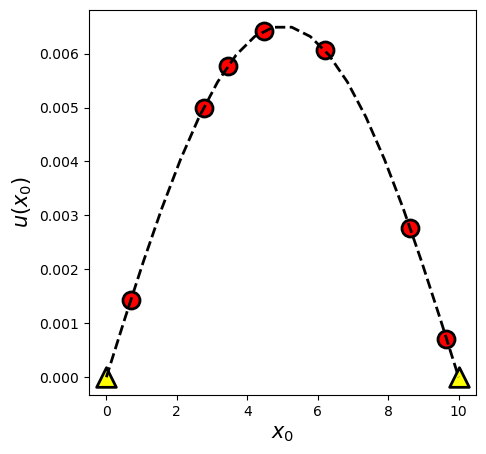

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

n = 20
l = xe - xo
X_dense = np.linspace(xo,xe,n).reshape(-1,1)
y_actually = (c/24)*(X_dense**4 - 2*l*X_dense**3 + l**3*X_dense)

U_df_sampled =  (c/24)*(X_df**4 - 2*l*X_df**3 + l**3*X_df)

plt.figure(figsize=(5,5))
plt.plot(X_dense,y_actually,color='black',linewidth=2,ls='--')


plt.scatter(X_b,U_b,color='yellow',marker='^',s=200,linewidths=2, edgecolors='black')
plt.scatter(X_df,U_df_sampled,color='red',s=150,linewidths=2, edgecolors='black')

plt.xlabel(r'$x_0$',fontsize = 15)
plt.ylabel(r'$u(x_0)$',fontsize = 15)

plt.show()

### AGraph Component Generator
AGraphs also require a component generator to generate elements of an acylic graph object. It plays a similar role as `get_random_float` in the ZeroMinExample jupyter notebook.

The dimension of the independent variable (x) is needed for the initialization of the component generator.  After initialization, mathematical operators can be added to the generator.  These operators constitute the building blocks from which the AGraphs will be made.

In this example, we use only two mathematical operators ($+$, $\times$) for convinience, but you can add more mathematical operators such as $/$, $pow$, etc. 

In [3]:
from bingo.symbolic_regression import ComponentGenerator

component_generator = ComponentGenerator(input_x_dimension=X_b.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("*")

C:\Users\hongs\anaconda3\lib\site-packages\bingo\symbolic_regression\__init__.py:31: UserWarning: Could not load C++ modules No module named 'bingocpp'
  warnings.warn(f"Could not load C++ modules {import_err}")


### AGraph Generator
The AGraph generator will use the component generator to generate `AGraphChromosome` individuals. In addion to the component generator, the desired size of the AGraphs is needed in initialization.  This size corresponds to the number of maximum number of commands possible in the AGraph. In other words, a larger size allows for more complex equations but comes at the cost of longer evaluation times.

In [4]:
from bingo.symbolic_regression import AGraphGenerator

stack_size = 13
agraph_generator = AGraphGenerator(agraph_size=stack_size,
                                   component_generator=component_generator, use_python=True)

In [5]:
agraph = agraph_generator()
print("f(X_0) = ", agraph)

f(X_0) =  X_0


Try rerunning the snippet above a few times to see some different equations produced by the genrator.  Note that X_0 represents the first dimension of the independent variable.  Also note that all numerical constants equal 1.0 unless local optimization is performed (more on this later).

### AGraph Variation
Set the the variation amongst the population per generation. 
AGraphCrossover is single-point.  Mutation contains several possible mutation strategies, most of which are single-point.  See documentation for more in depth description of mutation types and tailoring the mutation function. Both the crossover and mutation require the component generator.

In [6]:
from bingo.symbolic_regression import AGraphCrossover
from bingo.symbolic_regression import AGraphMutation

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)

### Evaluation: Differential Regression

$$f(\tilde{u}) = \left({\sqrt{\frac{1}{N}\sum_{i}^N(\tilde{u}_i - {ub}_i)^2}} + \sqrt{\frac{1}{N}\sum_{i}^N(\nabla^2\tilde{u}_i - M_i)^2}\right)_{\partial\Omega} + {\lambda\sqrt{\frac{1}{N}\sum_{i}^N(\nabla^4\tilde{u}_i - c)^2}}_{\Omega}$$

To evaluate differential equations, `DifferentialRegression` is developed. The above equation is the physics regularized fitness function (PR - fitness function) for Euler-Bernoulli equation where $\tilde{u}$ is a candidate individual. The PR - fitness function measures the error of the boundary value ($ub=0$ and $M=0$), and the error of the fourth-order ODE ($c = 5e-5$). `DifferentialRegression` extends `FitnessFunction`; hence, may be passed to `LocalOptFitnessFunction` object as an argument. This is then passed to an `Evaluation` object which will run `DifferentialRegression` on all `AGraph` individuals. 

The `LocalOptFitnessFunction` is responsible for finding the best numerical constants for the given differential regression.  The numerical constants are represented by "?" before local optimization has been performed (as you may have seen in the AGraph Generator section). 

In [7]:
from differential_regression import DifferentialRegression_TF
from bingo.local_optimizers.scipy_optimizer import ScipyOptimizer
from bingo.local_optimizers.local_opt_fitness import LocalOptFitnessFunction
from bingo.evaluation.evaluation import Evaluation


clo_type = 'root'
method = 'lm'
neumann_bc = True
differential_weight = 1

fitness = DifferentialRegression_TF(X_b, U_b, X_df, error_df_fn, 
                                    df_order = df_order,
                                    neumann_bc=neumann_bc,
                                    clo_type = clo_type, 
                                    differential_weight=differential_weight)

optimizer = ScipyOptimizer(fitness, method=method, param_init_bounds=[-5, 5])
local_opt_fitness = LocalOptFitnessFunction(fitness, optimizer)
evaluator = Evaluation(local_opt_fitness)

### Age Fitness Evolutionary Algorithm

The evoluaionary algorithm used in this example is `AgeFitnessEA`. This by default uses the `AgeFitnessSelection`. It also requires use of the `AGraphGenerator` in order to seed a random individuals.  The Age Fitness EA is used to combat premature convergence that can be seen in symbolic regression.

In [8]:
from bingo.evolutionary_algorithms.age_fitness import AgeFitnessEA

crossover_rate = 0.6
mutation_rate = 0.4
pop_size = 250

ea = AgeFitnessEA(evaluator, agraph_generator, crossover, mutation,
                  crossover_rate, mutation_rate, pop_size)

### Pareto Front

A `ParetoFront` hall of fame object is useful in symbolic regression for tracking the best individuals, where fitness and equation complexity are both taken into consideration. The secondary key must be supplied to the `ParetoFront` object. The primary key can optionally be supplied instead of the default use of fitness. 

In [9]:
from bingo.stats.pareto_front import ParetoFront

def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity)

### Evolution on an island
Once an `Island` is set up, evolution occurs in the same way as described in earlier examples.

In [10]:
from bingo.evolutionary_optimizers.island import Island

island = Island(ea, agraph_generator, pop_size, hall_of_fame=pareto_front)
print("Best individual\n f(X_0) =", island.get_best_individual())

Best individual
 f(X_0) = ((X_0)((-0.0014433303157542988 + X_0)(-0.0014433303157542988)))((X_0)((-0.0014433303157542988 + X_0)(-0.0014433303157542988)))


Run until convergence. Print the best result. We store each best individual in a list and use this to observe how the best solution evolves over time.

In [11]:
ERROR_TOLERANCE = 1e-18
verbose = True
verbose_frequency = 50

best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)

while island.get_best_fitness() > ERROR_TOLERANCE:
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)
    if verbose==True:
        if island.generational_age%verbose_frequency==0:
            print("Generation: ", island.generational_age)
            print("Best individual\n f(X_0) =", island.get_best_individual())
            print("Fitness = ",island.get_best_individual().fitness)

print("Success!")
print("Generation: ", island.generational_age)
print("Best individual\n f(X_0) =", island.get_best_individual())
print("Fitness = ",island.get_best_individual().fitness)

Success!
Generation:  48
Best individual
 f(X_0) = (((X_0)(-10.0 + X_0))(-100.0 + (X_0)(-10.0 + X_0)))(2.0833333333333334e-06)
Fitness =  2.3115267984821866e-20


We can look at the pareto then look at the Pareto front to see the tradeoff between fitness and complexity

In [12]:
import sympy

print(" FITNESS   COMPLEXITY    EQUATION")
for i,member in enumerate(pareto_front):
    exp = str(member)
    exp = exp.replace(')(',')*(')
    print("%.3e     " % member.fitness, member.get_complexity(),
          "     f(X_0) =", sympy.expand(exp))

 FITNESS   COMPLEXITY    EQUATION
2.312e-20      9      f(X_0) = 2.0833333333333334e-6*X_0**4 - 4.1666666666666668e-5*X_0**3 + 0.0020833333333333334*X_0
1.720e-04      7      f(X_0) = 2.0833332364747444e-6*X_0**4 - 4.3875032243108037e-5*X_0**3 + 0.00023100222525983617*X_0**2
2.072e-03      6      f(X_0) = 2.0832024003754039e-6*X_0**4 - 0.0014433303157542988*X_0
6.326e-03      5      f(X_0) = 2.083202306520958e-6*X_0**4
3.829e+05      3      f(X_0) = X_0**4
inf      1      f(X_0) = X_0


### Animation of evolution

In [13]:
def animate_data(list_of_best_indv, list_of_best_gens, X,Y):

    fig, ax = plt.subplots()
    
    num_frames = len(list_of_best_indv)
    
    x = X
    y_actually = Y
    y = list_of_best_indv
    g = list_of_best_gens
    plt.plot(X, Y, 'ro')
    points, = ax.plot(X, y[0].evaluate_equation_at(X), 'b')
    points.set_label('Generation :' + str(g[0]))
    legend = ax.legend(loc='upper right', shadow=True)
    
    def animate(i):
        ax.collections.clear()
        points.set_ydata(y[i].evaluate_equation_at(X))  # update the data
        points.set_label('Generation :' + str(g[i]))
        legend = ax.legend(loc='upper right')
        return points, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, points

    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.title("Best Individual in Island", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    plt.close()

    return animation.FuncAnimation(fig, animate, num_frames, init_func=init,
                                interval=250, blit=True)

In [14]:
from IPython.display import HTML
anim2 = animate_data(best_indv_values, best_indv_gen, X_dense,y_actually)
HTML(anim2.to_jshtml())